<a href="https://colab.research.google.com/github/tannguyen2512/cs-final-project/blob/master/diabetic_retinopathy_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare

## Download the dataset (only run once)

In [ ]:
import os

In [ ]:
if not os.path.exists('/content/resized-2015-2019-diabetic-retinopathy-detection.zip'):
    !kaggle datasets download -d c7934597/resized-2015-2019-diabetic-retinopathy-detection

In [ ]:
api_token = {"username":"talland","key":"60385cd2105d7ab6cfe161f266c447dc"}
import json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
if not os.path.exists('/content/resized-2015-2019-diabetic-retinopathy-detection.zip'):
    !kaggle datasets download -d c7934597/resized-2015-2019-diabetic-retinopathy-detection

In [ ]:
if not os.path.exists('/content/resized_traintest15_train19'):
    !unzip -n -q ./resized-2015-2019-diabetic-retinopathy-detection.zip -x resized_test19/* ;

In [ ]:
### OR By using directly from Google Cloud Service
# !pip install fsspec
# !pip install gcsfs

# GCS_PATH = 'gs://kds-a683652f772b5c920ffc24330c32fcf54b559630331c05ceb323a2a4' # <<<<<< FILL THE GOOGLE CLOUD SERVICE PATH EXTRACTED FROM KAGGLE NOTEBOOK HERE

# TEST
# import pandas as pd
# test = pd.read_csv(GCS_PATH+'/labels/traintestLabels15_trainLabels19.csv')
# test.head(3)

## Load library

In [ ]:
!pip install --upgrade Pillow
!pip install tensorflow-addons

Requirement already up-to-date: Pillow in /usr/local/lib/python3.7/dist-packages (8.2.0)


In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
import tqdm.notebook as tq
import pickle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow #Only in Colab

import tensorflow as tf
print("TensorFlow version: ",tf.__version__)
import tensorflow_addons as tfa
from tensorflow.data import Dataset

AUTOTUNE = tf.data.experimental.AUTOTUNE

TensorFlow version:  2.5.0


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# Check if GPU is ready to used (only for GPU runtime)
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5043445092479972834, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16183459840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3845217924634813833
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [ ]:
#@title skip
###### Import Tensorflow and activate TPU (not use TPU)
# %tensorflow_version 2.x
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow_addons as tfa

# import matplotlib.pyplot as plt
# import numpy as np

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#     print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#     raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# try:
#     tpu_strategy = tf.distribute.TPUStrategy(tpu)
# except:
#     tpu_strategy = tf.distribute.get_strategy()
# print('Number of replicas:', tpu_strategy.num_replicas_in_sync)

# AUTOTUNE = tf.data.experimental.AUTOTUNE

# print("Tensorflow version " + tf.__version__)

## Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Constants

In [ ]:
index_class = {0:'No_DR', 1:'Mild', 2:'Moderate', 3:'Severe', 4:'Proliferative_DR'}

# GCS_PATH = 'gs://kds-a683652f772b5c920ffc24330c32fcf54b559630331c05ceb323a2a4' # <<<<<< FILL THE GOOGLE CLOUD SERVICE PATH EXTRACTED FROM KAGGLE NOTEBOOK HERE
RAW_DATA_FOLDER = './resized_traintest15_train19'
FINAL_PROJECT_FOLDER = '/content/drive/MyDrive/final_project'
BATCH_SIZE = 16
SEED = 25
IMG_SIZE = 224

tf.random.set_seed(SEED)
np.random.seed(SEED)

## Load metadata of labeled images (2015 train + 2015 test + 2019 train)

In [ ]:
import pickle

def remove_corrupted(df):
    corrupted_filepath = os.path.join(FINAL_PROJECT_FOLDER,'corrupted.pkl')
    with open(corrupted_filepath, 'rb') as f:
        corrupted = pickle.load(f)
    df.drop(index = df[df['filename'].isin(corrupted)].index, inplace = True)
    return df

In [ ]:
def read_dataset_dataframe(csv_path = './labels/traintestLabels15_trainLabels19.csv', overwrite = False):
    '''
    Read the dataframe that contain image filename and labels
    '''
    save_file = os.path.join(FINAL_PROJECT_FOLDER,'traintestLabels15_trainLabels19.pkl')

    if (os.path.exists(save_file)) & (not overwrite) :
        with open(save_file, 'rb') as f:
            mod_df = pickle.load(f)
    else :
        df = pd.read_csv(csv_path)
        df.columns = ['filename', 'class']

        mod_df = df.copy()
        mod_df['class'] = mod_df['class'].astype(str)
        
        mod_df['fullpath'] = ''
        mod_df['height'] = 0
        mod_df['width'] = 0
        mod_df['year'] = 2019
        mod_df['s1_worse'] = 0
        mod_df['s2_worse'] = 0
        mod_df['s3_worse'] = 0
        mod_df['s4'] = 0

        def add_metadata(row):
            if '_' in row['filename'] : row['year'] = 2015
            row['filename'] = row['filename']+'.jpg'
            row['fullpath'] = os.path.join(RAW_DATA_FOLDER,row['filename'])
            tmp = Image.open(row['fullpath'])
            row['height'] = tmp.size[0]
            row['width'] = tmp.size[1]
            if row['class'] in ['1','2','3','4'] :  row['s1_worse'] = 1 
            if row['class'] in ['2','3','4'] :      row['s2_worse'] = 1 
            if row['class'] in ['3','4'] :          row['s3_worse'] = 1 
            if row['class'] == '4' :                row['s4'] = 1 
            return row
        mod_df = mod_df.apply(add_metadata, axis = 1)
        
        mod_df = remove_corrupted(mod_df)
            
        with open(save_file, 'wb') as f :
            pickle.dump(mod_df,f)

    return mod_df

In [ ]:
df = read_dataset_dataframe(overwrite = False)
df.sample(5)

filename class  ... s3_worse  s4
60755  21309_right.jpg     0  ...        0   0
1821    2270_right.jpg     0  ...        0   0
56476   17740_left.jpg     0  ...        0   0
70112   28955_left.jpg     0  ...        0   0
60042   20715_left.jpg     2  ...        0   0

[5 rows x 10 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92351 entries, 0 to 92363
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  92351 non-null  object
 1   class     92351 non-null  object
 2   fullpath  92351 non-null  object
 3   height    92351 non-null  int64 
 4   width     92351 non-null  int64 
 5   year      92351 non-null  int64 
 6   s1_worse  92351 non-null  int64 
 7   s2_worse  92351 non-null  int64 
 8   s3_worse  92351 non-null  int64 
 9   s4        92351 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 7.8+ MB


## Class weight

In [ ]:
sample_count = list(np.bincount(df['class']))
sample_count = np.array(sample_count)
sample_count

array([67141,  6573, 14148,  2280,  2209])

In [ ]:
weight = 1 / np.array(sample_count) * sample_count.sum() / sample_count.shape[0]
for i in range(len(weight)) :
    print('Weight for class {}: {:.3f}'.format(i, weight[i]))

Weight for class 0: 0.275
Weight for class 1: 2.810
Weight for class 2: 1.305
Weight for class 3: 8.101
Weight for class 4: 8.361


In [ ]:
class_weight = {i: weight[i] for i in range(len(weight)) }
class_weight

{0: 0.2750956941362208,
 1: 2.810010649627263,
 2: 1.3054990104608426,
 3: 8.100964912280702,
 4: 8.361339972838389}

## Split data into train validation set

In [ ]:
def split_train_val_test_from_df(origin, subset_ratio = 1, val_ratio = 0.1, test_ratio = 0.1, seed = None, balance_train = False, balance_val = False, balance_dataset = False):
    '''
    Split the DataFrame containing image filenames and their class
    into smaller DataFrame for training and validation.
    The function does stratified sampling.
    Inputs are: dataframe df, ratio for validation data, and a seed for random state
    '''
    def resample_minor(minor_df, major_df):
        ids = np.arange(minor_df.shape[0])
        choices = np.random.choice(ids, major_df.shape[0])
        res = minor_df.iloc[choices]
        return res

    train_df = pd.DataFrame()
    val_df = pd.DataFrame()
    test_df = pd.DataFrame()

    if balance_dataset: 
        c0_sample = df[df['class']=='0']
        c1_sample = df[df['class']=='1']
        res_c1 = resample_minor(c1_sample, c0_sample)
        c2_sample = df[df['class']=='2']
        res_c2 = resample_minor(c2_sample, c0_sample)
        c3_sample = df[df['class']=='3']
        res_c3 = resample_minor(c3_sample, c0_sample)
        c4_sample = df[df['class']=='4']
        res_c4 = resample_minor(c4_sample, c0_sample)

        oversampling_df = pd.concat([c0_sample, res_c1, res_c2, res_c3, res_c4], axis = 0)
        oversampling_df = oversampling_df.sample(frac = 1, random_state = seed)
        origin = oversampling_df

    if balance_train: 
        class_n_train = int(origin.shape[0] * subset_ratio * (1 - val_ratio - test_ratio))
        class_n_train = class_n_train // origin['class'].nunique()
        class_n_train = min(class_n_train, origin['class'].value_counts().min())

    if balance_val: 
        class_n_val = int(origin.shape[0] * subset_ratio * val_ratio)
        class_n_val = class_n_val // origin['class'].nunique()
        class_n_val = min(class_n_val, origin['class'].value_counts().min() - class_n_train)
        
    for c in origin['class'].unique():
        subset = origin[origin['class'] == c]
        subset = subset.sample(frac = 1, random_state = seed)
        
        if balance_train :
            n_train = class_n_train 
        else:  
            n_train = int((1 - val_ratio - test_ratio) * subset_ratio * subset.shape[0])
        if balance_train :
            n_val = class_n_val 
        else:  
            n_val = int(val_ratio * subset_ratio * subset.shape[0])
        n_test = int(test_ratio * subset_ratio * subset.shape[0])
        
        train_split_ix = n_train
        val_split_ix = train_split_ix + n_val
        test_split_ix = val_split_ix + n_test
        
        train_subset = subset.iloc[:train_split_ix,:]
        val_subset = subset.iloc[train_split_ix:val_split_ix,:]
        test_subset = subset.iloc[val_split_ix:test_split_ix,:]
        
        train_df = pd.concat([train_df, train_subset])
        val_df = pd.concat([val_df, val_subset])
        test_df = pd.concat([test_df, test_subset])
        
    a = origin['class'].value_counts().sort_index()
    b = train_df['class'].value_counts().sort_index()
    c = val_df['class'].value_counts().sort_index()
    d = test_df['class'].value_counts().sort_index()
    e = pd.concat([a,b,c,d], axis = 1)
    
    e.columns = ['Full','Train','Validation','Test']
    print("Split dataframes class counts:")
    # print(e)
    tmp = np.sum(e, axis=0)
    tmp = pd.DataFrame(tmp).transpose()
    tmp.index = ['Total']
    # print(tmp)
    print(pd.concat([e, tmp], axis = 0))

    train_df = train_df.sample(frac = 1, random_state = seed)
    val_df = val_df.sample(frac = 1, random_state = seed)
    test_df = test_df.sample(frac = 1, random_state = seed)
    
    return train_df, val_df, test_df

In [ ]:
#@title skip
# subset_ratio = 0.08
# val_ratio = 0.2
# test_ratio = 0.0

# train_df, val_df, test_df = split_train_val_test_from_df(
#     df, subset_ratio = subset_ratio, 
#     val_ratio = val_ratio, 
#     test_ratio = test_ratio,
#     seed = SEED,
#     balance_train = False, 
#     balance_val = False,
#     balance_dataset = True)

In [ ]:
subset_ratio = 0.08
val_ratio = 5000
test_ratio = 20000

train_df, val_df = train_test_split(df, test_size=val_ratio, train_size=test_ratio, random_state=SEED, stratify=df['class'])

print('Dataset distribution')
print(df['class'].value_counts().sort_index())
print(df.shape)
print('='*20)
print('Train set distribution')
print(train_df['class'].value_counts().sort_index())
print(train_df.shape)
print('='*20)
print('Validation set distribution')
print(val_df['class'].value_counts().sort_index())
print(val_df.shape)

Dataset distribution
0    67141
1     6573
2    14148
3     2280
4     2209
Name: class, dtype: int64
(92351, 10)
Train set distribution
0    14540
1     1424
2     3064
3      494
4      478
Name: class, dtype: int64
(20000, 10)
Validation set distribution
0    3635
1     356
2     766
3     123
4     120
Name: class, dtype: int64
(5000, 10)


In [ ]:
train_df['class'].value_counts().sort_index() / train_df.shape[0]

0    0.7270
1    0.0712
2    0.1532
3    0.0247
4    0.0239
Name: class, dtype: float64

In [ ]:
val_df['class'].value_counts().sort_index() / val_df.shape[0]

0    0.7270
1    0.0712
2    0.1532
3    0.0246
4    0.0240
Name: class, dtype: float64

# Preprocessing

## Dummy function

(814, 1023, 3)
(224, 224, 3)


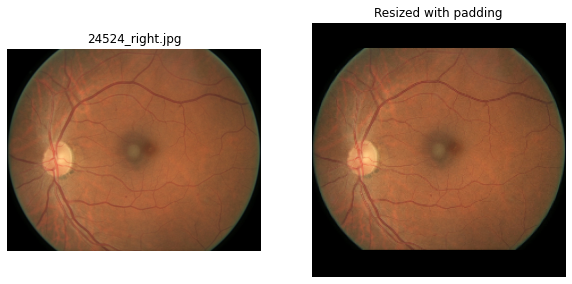

In [ ]:
#@title resize with padding
def dummy_func():
    dummy_file = df.sample(1)
    dummy = tf.io.read_file(dummy_file.fullpath.values[0])
    dummy = tf.io.decode_jpeg(dummy)
    print(dummy.shape)
    resize_pad = tf.image.resize_with_pad(dummy, IMG_SIZE, IMG_SIZE)
    print(resize_pad.shape)

    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(dummy.numpy().astype("uint8"))
    plt.title(dummy_file.filename.values[0])
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(resize_pad.numpy().astype("uint8"))
    plt.title("Resized with padding")
    plt.axis("off")

dummy_func()

(1021, 1023, 3)


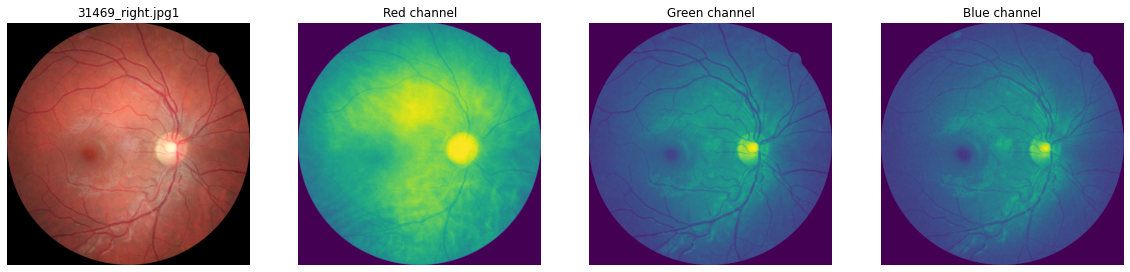

In [ ]:
#@title separate channel
def dummy_func():
    dummy_file = df.sample(1)
    dummy = tf.io.read_file(dummy_file.fullpath.values[0])
    dummy = tf.io.decode_jpeg(dummy)
    print(dummy.shape)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,4,1)
    plt.imshow(dummy.numpy().astype("uint8"))
    plt.title(dummy_file['filename'].values[0] + dummy_file['class'].values[0])
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(dummy[:,:,0].numpy().astype("uint8"))
    plt.title("Red channel")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(dummy[:,:,1].numpy().astype("uint8"))
    plt.title('Green channel')
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(dummy[:,:,2].numpy().astype("uint8"))
    plt.title('Blue channel')
    plt.axis("off")

dummy_func()

(1024, 1022, 3)
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


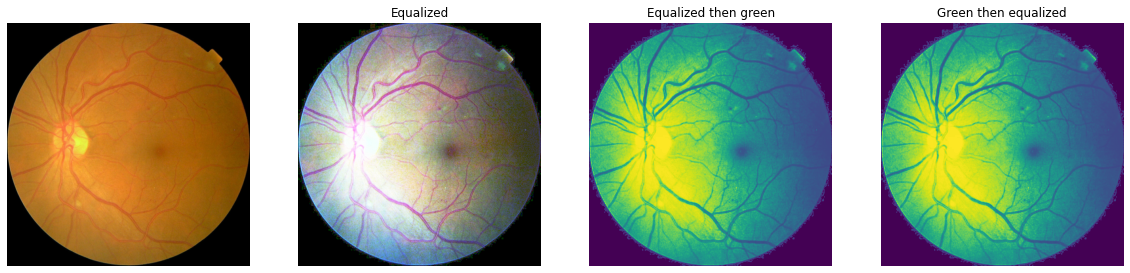

In [ ]:
#@title histogram equalization
def dummy_func(filepath = None):
    if filepath == None :
        dummy_file = df.sample(1)
        dummy = tf.io.read_file(dummy_file.fullpath.values[0])
    else :
        dummy = tf.io.read_file(filepath)
    dummy = tf.io.decode_jpeg(dummy)
    print(dummy.shape)
    
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    plt.imshow(dummy.numpy().astype("uint8"))
    if filepath == None :
        plt.title(dummy_file['filename'].values[0] + " class " + dummy_file['class'].values[0])
    plt.axis("off")

    pdummy = tfa.image.equalize(dummy, bins = 256)
    plt.subplot(1,4,2)
    plt.imshow(pdummy.numpy().astype("uint8"))
    plt.title("Equalized")
    plt.axis("off")
    
    pdummy = tfa.image.equalize(dummy, bins = 256)
    plt.subplot(1,4,3)
    plt.imshow(pdummy[:,:,1].numpy().astype("uint8"))
    plt.title("Equalized then green")
    plt.axis("off")

    pdummy = tfa.image.equalize(dummy[:,:,1], bins = 256)
    plt.subplot(1,4,4)
    plt.imshow(pdummy.numpy().astype("uint8"))
    plt.title("Green then equalized")
    plt.axis("off")

dummy_func('/content/resized_traintest15_train19/32711_left.jpg')

## Preprocess in openCV

CPU times: user 1.02 s, sys: 55.3 ms, total: 1.07 s
Wall time: 1.19 s


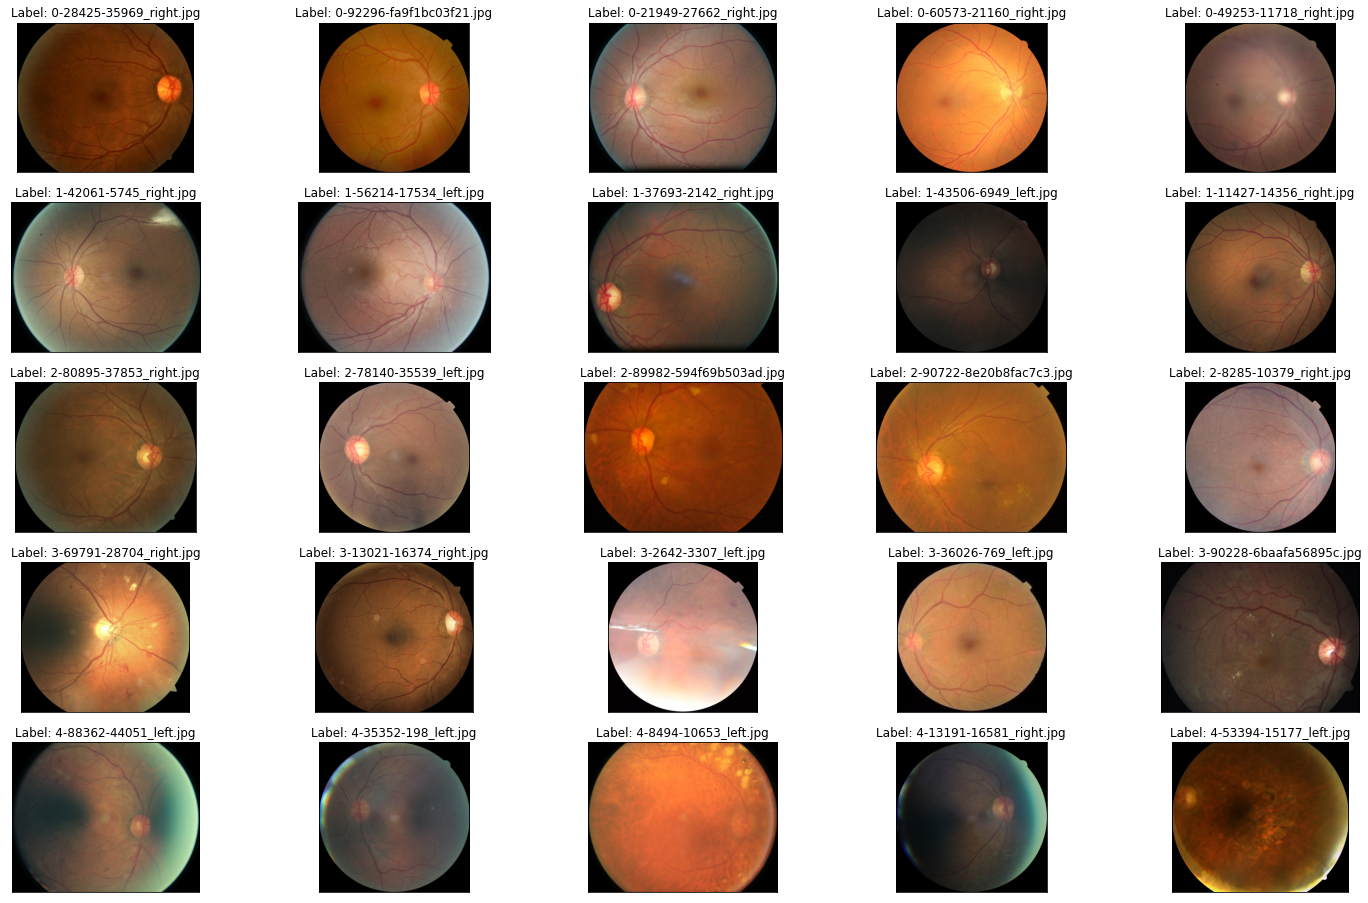

In [ ]:
#@title sample images (original)
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_df['class'].unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['class'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, int(class_id) * 5 + i + 1, xticks=[], yticks=[])
        path=row['fullpath']
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        
        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (int(class_id), idx, row['filename']) )

### Improve image lightning condition

CPU times: user 1.53 s, sys: 14.8 ms, total: 1.54 s
Wall time: 1.2 s


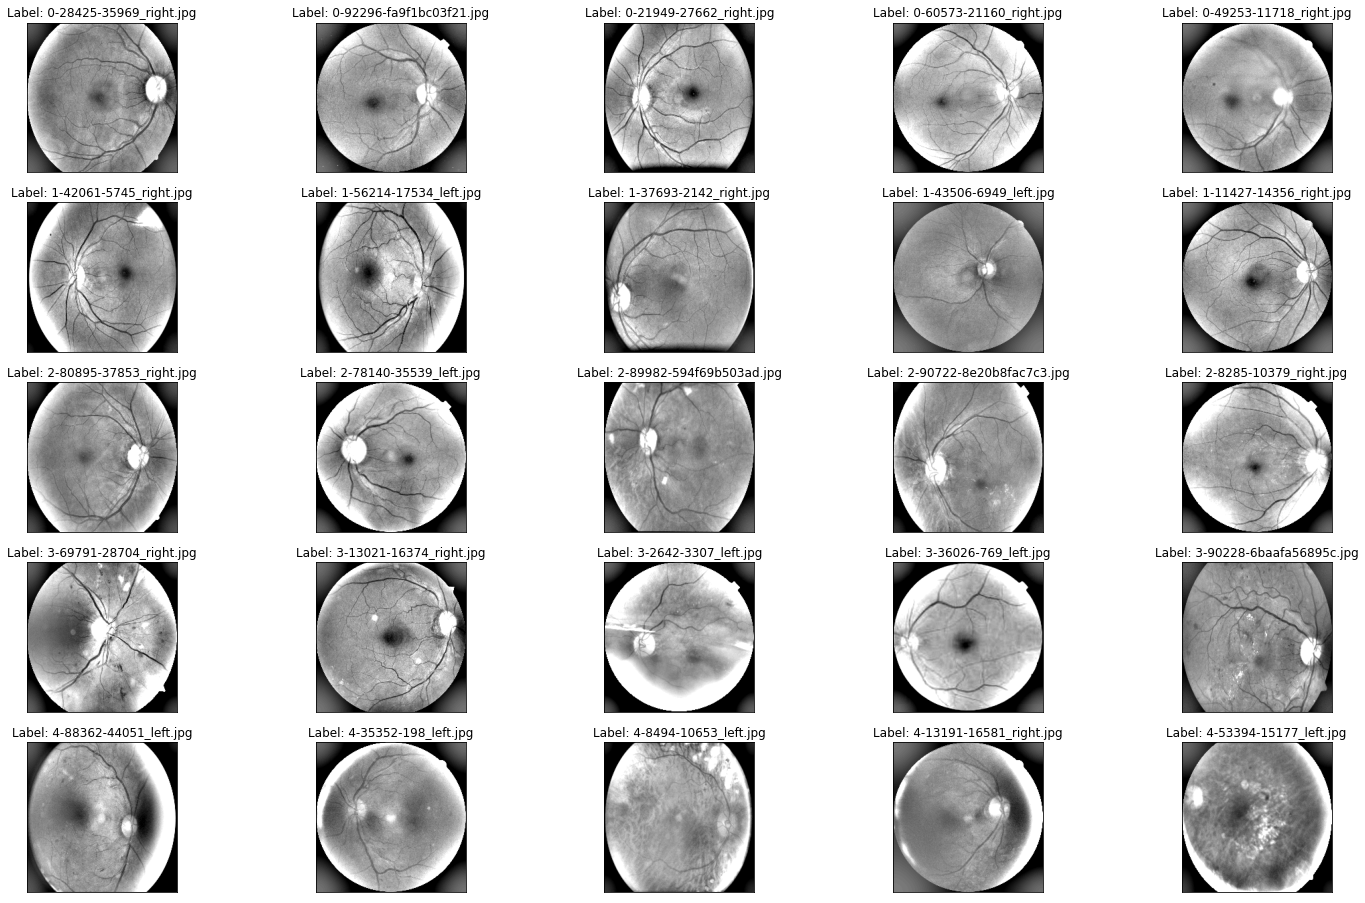

In [ ]:
#@title 
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_df['class'].unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['class'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, int(class_id) * 5 + i + 1, xticks=[], yticks=[])
        path=row['fullpath']
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (int(class_id), idx, row['filename']) )

In [ ]:
# @title skip
# TF version (gave up)
# %%time
# fig = plt.figure(figsize=(25, 16))
# for class_id in sorted(train_df['class'].unique()):
#     for i, (idx, row) in enumerate(train_df.loc[train_df['class'] == class_id].sample(5, random_state=SEED).iterrows()):
#         ax = fig.add_subplot(5, 5, int(class_id) * 5 + i + 1, xticks=[], yticks=[])
#         path=row['fullpath']
#         img = tf.io.read_file(path)
#         img = tf.io.decode_jpeg(img, 3)
#         img = tf.image.rgb_to_grayscale(img)
#         img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        
#         gauss_filter = cv2.GaussianBlur( img.numpy() , (0,0) , IMG_SIZE/10)
#         img = ( 4*tf.squeeze(img,2) ) + (-4 * gauss_filter) + 128
        
#         plt.imshow(img, cmap='gray')
#         ax.set_title('Label: %d-%d-%s' % (int(class_id), idx, row['filename']) )

In [ ]:
#@title skip
#  Compare cv2 and tf version
# OpenCV:   Y ←0.299⋅R+0.587⋅G+0.114⋅B
# TF:       rgb_weights = [0.2989, 0.5870, 0.1140]
# %%time
# plt.figure(figsize=(10, 15))
# for i, (idx, row) in enumerate(train_df.sample(5, random_state=SEED).iterrows()):
#     plt.subplot(5, 2, i * 2 + 1)
#     path=row['fullpath']

#     img_cv = cv2.imread(path)
#     img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
#     img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)
#     print(img_cv.dtype)
#     print(np.max(img_cv))
#     img_cv = cv2.resize(img_cv, (IMG_SIZE, IMG_SIZE))
#     # cv_gauss = cv2.GaussianBlur( img_cv , (0,0) , IMG_SIZE/10)
#     # img_cv = cv2.addWeighted ( img_cv,4, cv_gauss ,-4 ,128) # the trick is to add this line
    
#     # plt.imshow(img_cv, cmap='gray')
#     # plt.title('%d-%s' % (idx, row['filename']) )
#     # plt.axis('off')

#     # plt.subplot(5, 2, i * 2 + 2)
#     img_tf = tf.io.read_file(path)
#     img_tf = tf.io.decode_jpeg(img_tf, 3, dct_method='INTEGER_ACCURATE')
#     img_tf = tf.image.rgb_to_grayscale(img_tf)
#     print(img_tf.dtype)
#     print(np.max(img_tf))

#     img_tf = tf.image.resize(img_tf, (IMG_SIZE, IMG_SIZE))

#     # img_tf = ( 4*tf.squeeze(img_tf,2) ) + (-4 * cv_gauss) + 128
    
#     img_tf = tf.squeeze(img_tf,2)

#     plt.imshow(np.abs(img_cv - img_tf), cmap='gray')
#     plt.title('%d-%s' % (idx, row['filename']) )
#     plt.axis('off')

#     break

I want to translate the cv2 code to tensorflow, but sadly the result of are not equivalent, right from the image-reading step :( :( :(

=> Use opencv for preprocessing, not utilize the power of GPU

In [ ]:
#@title crop_image_from_gray
def crop_image_from_gray(img,tol=7):
    '''
    Crop the image if the grayscale value < tolerance
    '''
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
    
        return img

In [ ]:
#@title load_ben_color
# def crop_image1(img,tol=7):
#     # img is image data
#     # tol  is tolerance
        
#     mask = img>tol
#     return img[np.ix_(mask.any(1),mask.any(0))]



def load_ben_color(path, sigmaX=10):
    '''
    Load the image, crop it based on its grayscale, then resize and enhance the lightning-condition
    '''
    # print("From load_ben_color ",type(path),path)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    # print(type(image))
    return image

CPU times: user 1.69 s, sys: 28.9 ms, total: 1.72 s
Wall time: 1.49 s


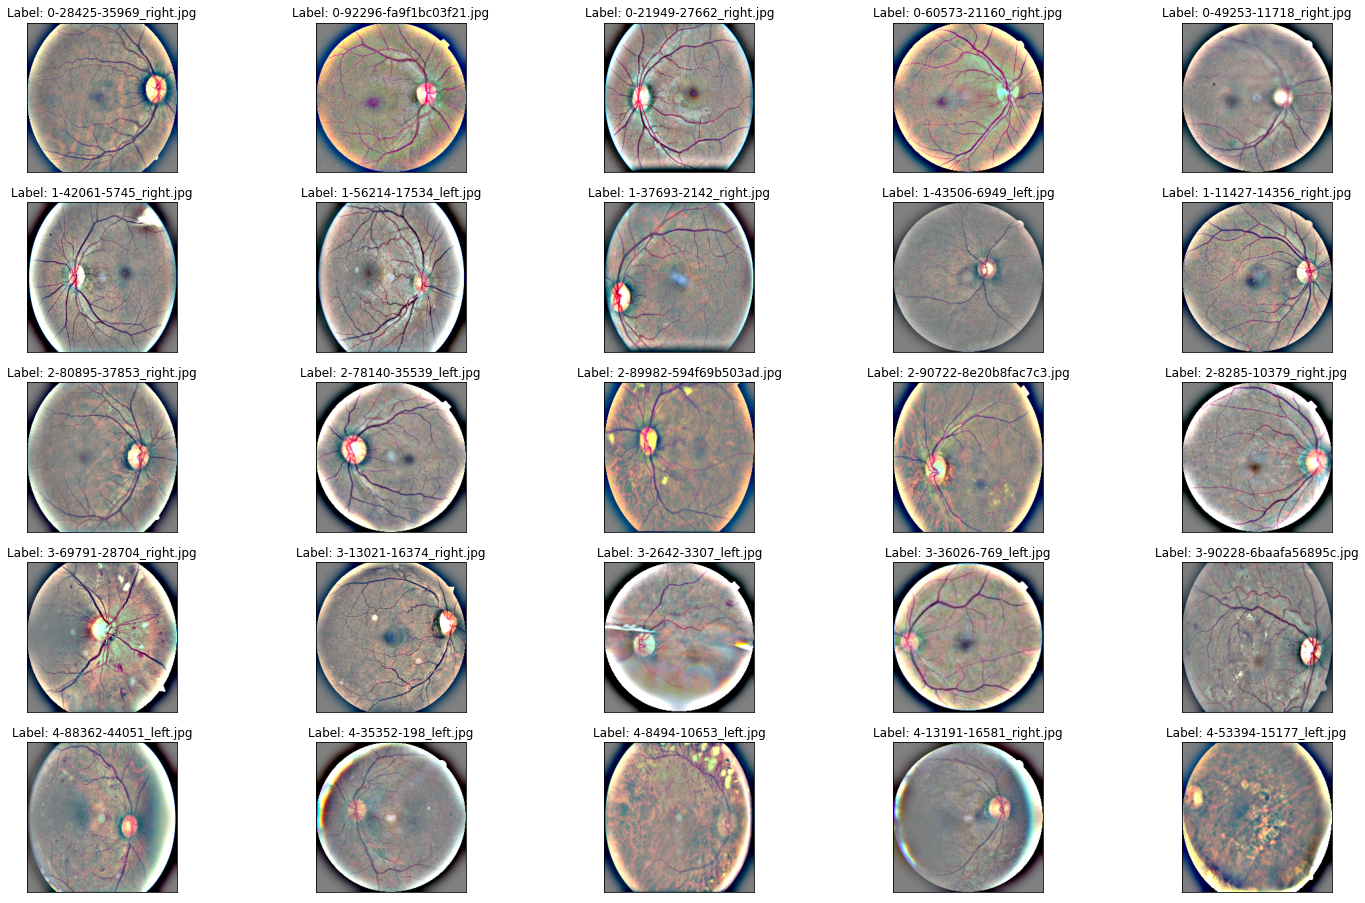

In [ ]:
#@title apply load_ben_color on samples
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_df['class'].unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['class'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, int(class_id) * 5 + i + 1, xticks=[], yticks=[])
        path=row['fullpath']
        image = load_ben_color(path)

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (int(class_id), idx, row['filename']) )

In [ ]:
#@title circle_crop
def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre, also apply lightning condition adjustment
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    # img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

CPU times: user 1.83 s, sys: 25.5 ms, total: 1.85 s
Wall time: 1.79 s


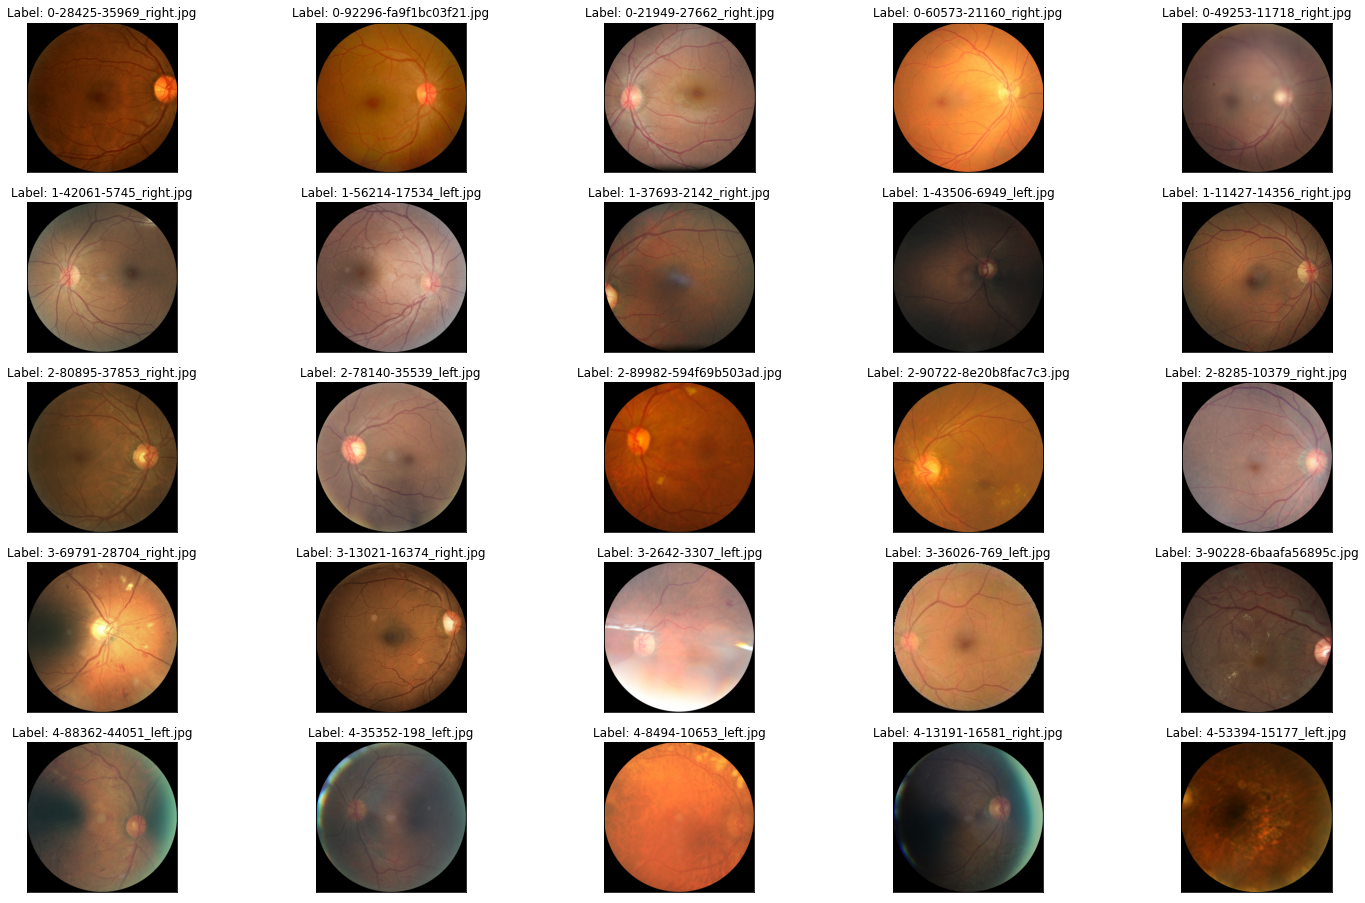

In [ ]:
#@title apply circle_crop on samples
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_df['class'].unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['class'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, int(class_id) * 5 + i + 1, xticks=[], yticks=[])
        path=row['fullpath']
        image = circle_crop(path)

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (int(class_id), idx, row['filename']) )

## Preprocess function

### Function

In [ ]:
def circle_slice(img):
    height, width, depth = img.shape    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    return img

def square_slice(img):
    height, width, depth = img.shape    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y)) - (10 if np.amin((height/width,width/height)) < 0.92 else 100)

    square_img = img[(y-r):(y+r),(x-r):(x+r),:]
    return square_img

In [ ]:
# @ title load_ben_circle_crop
def load_ben_circle_crop(path, sigmaX=10):   
    """
    Create circular crop around image centre, also apply lightning condition adjustment
    """    
    
    img = cv2.imread(path)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = augment_image(img) ##############
    
    img = square_slice(img) # square_slice circle_slice
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img     

In [ ]:
def ben_color(img, sigmaX = 10):
    '''
    Improve lightning condition
    '''
    return cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , sigmaX) ,-4 ,128)

In [ ]:
def augment_image(img, label):
    # img = tfa.image.equalize(img, bins = 256)
    # img = img.numpy()
    if type(img) != np.ndarray :
        img = img.numpy()
    # img = tf.keras.preprocessing.image.random_shift(img, 0.1, 0.1, row_axis=0, col_axis=1, channel_axis=2,fill_mode='constant', cval=0.0)
    img = tf.image.random_crop(img, size=[IMG_SIZE, IMG_SIZE, 3])
    if type(img) != np.ndarray : 
        img = img.numpy()
    img = tf.keras.preprocessing.image.random_rotation(img, 90, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0.0)
    img = tf.keras.preprocessing.image.random_shear(img, 10, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0.0, interpolation_order=1)
    img = ben_color(img)

    if type(img) != np.ndarray :
        img = img.numpy()

    return img, label
def parse_func_aug(img_name, label):
    oimage, olabel = tf.py_function(augment_image, [img_name,label], (tf.float32, tf.uint8))
    oimage.set_shape([IMG_SIZE, IMG_SIZE, 3])
    olabel.set_shape([5])
    return oimage, olabel

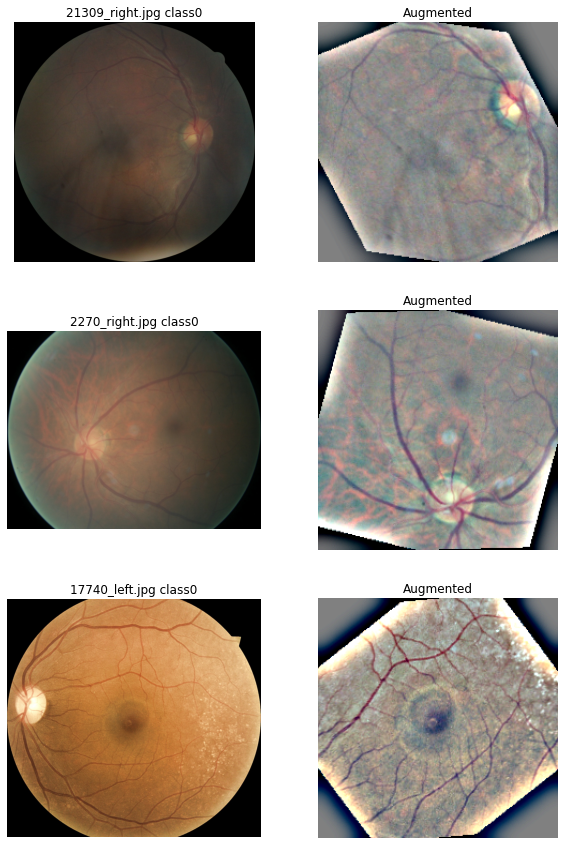

In [ ]:
def dummy():

    def quick_plot(img, title):
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    ncols = 2
    tmp = df.sample(3, random_state=SEED)
    plt.figure(figsize=(10,15))
    for i in range(tmp.shape[0]) :
        img = cv2.imread(tmp.iloc[i,2])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(3,ncols, i*ncols + 1)
        quick_plot(img,tmp.iloc[i,0]+' class'+tmp.iloc[i,1])
        
        plt.subplot(3,ncols, i*ncols + 2)
        pltimg = square_slice(img)
        pltimg = cv2.resize(pltimg, (IMG_SIZE+25, IMG_SIZE+25))
        pltimg,_ = augment_image(pltimg, tmp.iloc[i,1])
        quick_plot(pltimg,'Augmented')
        
dummy()

In [ ]:
def preprocess_train(img_name, label) :
    if (type(img_name) != str)  :
        img_name = img_name.numpy().decode("utf-8")
    
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = square_slice(img) # square_slice circle_slice
    # if type(img) != np.ndarray :
    #     img = img.numpy()
    img = cv2.resize(img, (IMG_SIZE+25, IMG_SIZE+25))
    img = img.astype('uint8')

    label = tf.keras.utils.to_categorical(label, num_classes=5)
    label = tf.cast(label,tf.uint8)
    return img, label

def parse_func_train(img_name, label):
    '''
    Wrap the preprocess function (with cv2 inside) with tf.py_function 
    so that it can run inside dataset API pipeline,
    as well as can be placed on GPU and can work with eager tensors.
    
    Need to specify the input tensor, and the output dtype
    '''
    oimage, olabel = tf.py_function(preprocess_train, [img_name,label], (tf.uint8, tf.uint8))
    oimage.set_shape([IMG_SIZE+25, IMG_SIZE+25, 3])
    olabel.set_shape([5])
    return oimage, olabel

In [ ]:
def preprocess_test(img_name, label) :
    
    if type(img_name) != str :
        img_name = img_name.numpy().decode("utf-8")
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = ben_color(img)
    img = img.astype('float32')

    label = tf.keras.utils.to_categorical(label, num_classes=5)
    label = tf.cast(label,tf.uint8)
    return img, label

def parse_func_test(img_name, label):
    '''
    Wrap the preprocess function (with cv2 inside) with tf.py_function 
    so that it can run inside dataset API pipeline,
    as well as can be placed on GPU and can work with eager tensors.
    
    Need to specify the input tensor, and the output dtype
    '''
    oimage, olabel = tf.py_function(preprocess_test, [img_name,label], (tf.float32, tf.uint8))
    oimage.set_shape([IMG_SIZE, IMG_SIZE, 3])
    olabel.set_shape([5])
    return oimage, olabel

(-0.5, 223.5, 223.5, -0.5)

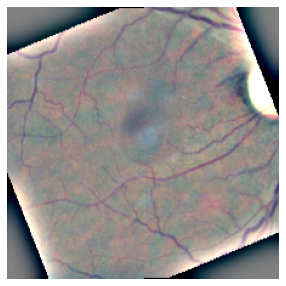

In [ ]:
sample = df.sample(1)
img = cv2.imread(sample['fullpath'].iloc[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = crop_image_from_gray(img)
img = square_slice(img)
img = cv2.resize(img, (IMG_SIZE+25, IMG_SIZE+25))
# img = img.astype('float32')
if type(img) != np.ndarray :
    img = img.numpy()
# img = tf.keras.preprocessing.image.random_shift(img, 0.1, 0.1, row_axis=0, col_axis=1, channel_axis=2,fill_mode='constant', cval=0.0)
img = tf.image.random_crop(img, size=[IMG_SIZE, IMG_SIZE, 3])
if type(img) != np.ndarray : 
    img = img.numpy()
img = tf.keras.preprocessing.image.random_rotation(img, 90, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0.0)
img = tf.keras.preprocessing.image.random_shear(img, 10, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0.0, interpolation_order=1)
img = ben_color(img)

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')

### Test preprocessing in tf.data.Dataset

"TypeError: 'NoneType' object cannot be interpreted as an integer" appears when I remove "GREEN extraction"

Swapping resize and equalization show that the **equalization** issues this message

Priting out the shape and type at each step of the `preprocess` function show that after the `tf.cast` step, the number of channels is `None`. Meanwhile, after `tf.expand_dims`, the number of channels is specified (as 1)

Documentation of `tfa.image.equalize` states that: "The rank must be statically known (the shape is not TensorShape(None))." So this function does not accept `None` shape.


=> Adding `tf.reshape` after `tf.cast` to ensure the number of channels

#### On individual file

In [ ]:
# test error with preprocess with dataset if any
(x, y) = (0,5)
all_img_path = df['fullpath'][x:y].values
all_label = df['class'][x:y].values

for path, label in tq.tqdm(zip(all_img_path, all_label)) :
    # try :
        preprocess_train(path, label)
        parse_func_train(path, label)
        preprocess_test(path, label)
        parse_func_test(path, label)

        img, label = parse_func_train(path, label)
        augment_image(img, label)
        parse_func_aug(img, label)
    # except:
    #     print("Error: ",path, label)

#### On train mode

In [ ]:
all_path = df['fullpath'].values
all_class = df['class'].values
checkds = Dataset.from_tensor_slices((all_path, all_class))
checkds = checkds.map(parse_func_train, num_parallel_calls = AUTOTUNE)
checkds = checkds.shuffle(1000)
checkds = checkds.cache()
checkds = checkds.map(parse_func_aug, num_parallel_calls = AUTOTUNE)
checkds = checkds.batch(4)
checkds = checkds.prefetch(AUTOTUNE)

CPU times: user 50.1 s, sys: 918 ms, total: 51 s
Wall time: 26.8 s


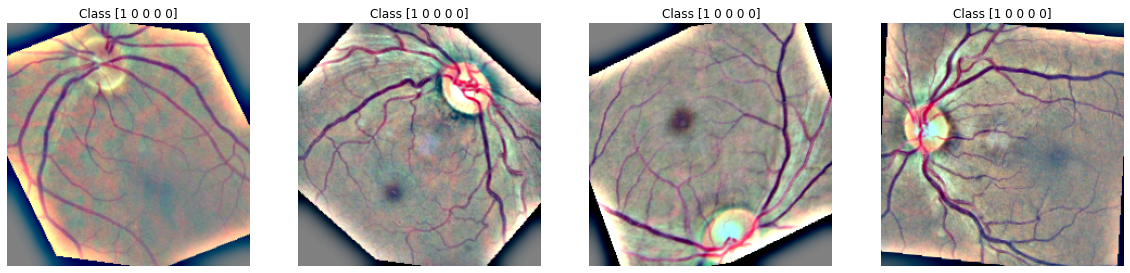

In [ ]:
%%time
image_batch, label_batch = next(iter(checkds))

img_ix = 1
ncols = 4
nrows = image_batch.shape[0] // ncols
plt.figure(figsize=(20,10))
    
for img in image_batch :
    plt.subplot(nrows,ncols,img_ix)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title("Class " + str(label_batch[img_ix - 1].numpy()))
    plt.axis("off")
    img_ix +=1

#### On test mode

In [ ]:
all_path = df['fullpath'].values
all_class = df['class'].values
checkds = Dataset.from_tensor_slices((all_path, all_class))
checkds = checkds.map(parse_func_test, num_parallel_calls = AUTOTUNE)
checkds = checkds.shuffle(1000)
checkds = checkds.cache()
checkds = checkds.batch(4)
checkds = checkds.prefetch(AUTOTUNE)

CPU times: user 1min 5s, sys: 1 s, total: 1min 6s
Wall time: 34.3 s


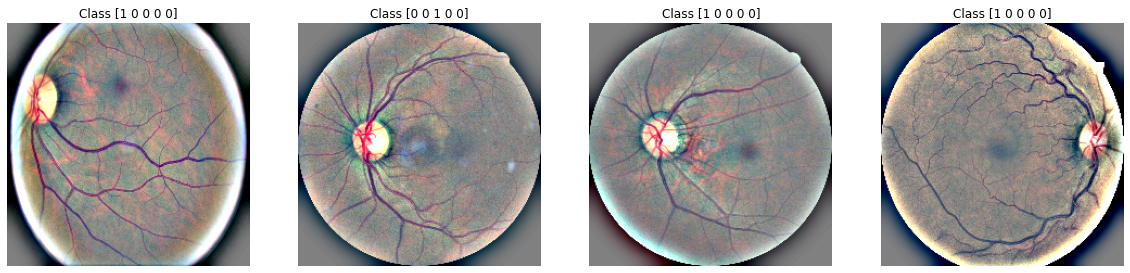

In [ ]:
%%time
image_batch, label_batch = next(iter(checkds))

img_ix = 1
ncols = 4
nrows = image_batch.shape[0] // ncols
plt.figure(figsize=(20,10))
    
for img in image_batch :
    plt.subplot(nrows,ncols,img_ix)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title("Class " + str(label_batch[img_ix - 1].numpy()))
    plt.axis("off")
    img_ix +=1

# Make generators

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def make_train_ds(train_df):
    input = train_df['fullpath']
    output = train_df['class']
    train_ds = Dataset.from_tensor_slices((input, output))
    train_ds = train_ds.map(parse_func_train, num_parallel_calls = AUTOTUNE)
    train_ds = train_ds.shuffle(1000)
    train_ds = train_ds.cache()
    train_ds = train_ds.map(parse_func_aug, num_parallel_calls = AUTOTUNE)
    train_ds = train_ds.batch(BATCH_SIZE)
    train_ds = train_ds.prefetch(AUTOTUNE)
    return train_ds

In [ ]:
train_ds = make_train_ds(train_df)
# properly check shape and dtype of input and label generated from Dataset
# image_batch, label_batch = next(iter(train_ds))
# print(tf.TensorSpec.from_tensor(image_batch) , tf.TensorSpec.from_tensor(label_batch))

In [ ]:
def make_val_ds(val_df):
    input = val_df['fullpath']
    output = val_df['class']
    val_ds = Dataset.from_tensor_slices((input, output))
    val_ds = val_ds.map(parse_func_test, num_parallel_calls = AUTOTUNE)
    val_ds = val_ds.cache()
    val_ds = val_ds.batch(BATCH_SIZE)
    val_ds = val_ds.prefetch(AUTOTUNE)
    return val_ds

In [ ]:
val_ds = make_val_ds(val_df)
# val_image_batch, val_label_batch = next(iter(val_ds))
# print(tf.TensorSpec.from_tensor(val_image_batch) , tf.TensorSpec.from_tensor(val_label_batch))

# Make callbacks

In [ ]:
def make_callbacks() :
    cb_earlystop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-2,
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
    return [cb_earlystop]

# Make baseline models 

## Helpers

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_acc_loss(history, baseline_hist = None, auc = False):
    train_acc = history.history['accuracy']
    val_acc = None
    val_loss = None
    if 'val_accuracy' in history.history.keys(): 
        val_acc = history.history['val_accuracy'] 
    train_loss = history.history['loss']
    if 'val_loss' in history.history.keys():
        val_loss = history.history['val_loss'] 
    if 'val_accuracy' in history.history.keys(): 
        val_acc = history.history['val_accuracy'] 
    if auc:
        train_auc = hi

    epochs = range(1,len(train_acc)+1)

    if baseline_hist is not None:
        base_train_acc = baseline_hist.history['accuracy'][:len(train_acc)]
        if 'val_accuracy' in history.history.keys():
            base_val_acc = baseline_hist.history['val_accuracy'][:len(train_acc)] 
        base_train_loss = baseline_hist.history['loss'][:len(train_acc)]
        if 'val_loss' in history.history.keys():
            base_val_loss = baseline_hist.history['val_loss'][:len(train_acc)] 

    plt.figure(figsize = (20,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_acc, 'b', label = 'Train accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
    if baseline_hist is not None:
        plt.plot(epochs, base_train_acc, 'b--', alpha = 0.3, label = 'Base model train accuracy')
        if base_val_acc:
            plt.plot(epochs, base_val_acc, 'r--', alpha = 0.3, label = 'Base model validation accuracy')
    plt.legend()
    plt.title('Training and validataion accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochs, train_loss, 'b', label = 'Train loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
    if baseline_hist is not None:
        plt.plot(epochs, base_train_loss, 'b--', alpha = 0.3, label = 'Base model train loss')
        if base_val_loss:
            plt.plot(epochs, base_val_loss, 'r--', alpha = 0.3, label = 'Base model validation loss')
    plt.legend()
    plt.title('Train and validataion loss')

In [ ]:
# def plot_cm(labels, predictions, p=0.5):
#   cm = confusion_matrix(labels, predictions > p)
#   plt.figure(figsize=(5,5))
#   sns.heatmap(cm, annot=True, fmt="d")
#   plt.title('Confusion matrix @{:.2f}'.format(p))
#   plt.ylabel('Actual label')
#   plt.xlabel('Predicted label')

#   print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
#   print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
#   print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
#   print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
#   print('Total Fraudulent Transactions: ', np.sum(cm[1]))

## DenseNet121

In [ ]:
from tensorflow.keras.applications import densenet

### Build model

In [ ]:
base_densenet = tf.keras.applications.densenet.DenseNet121(
    include_top=False, 
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3) 
)
base_densenet.trainable = False

29089792/29084464 [==============================] - 1s 0us/step


In [ ]:
def make_tl_densenet():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE,3))
    x = densenet.preprocess_input(inputs)
    x = base_densenet(x, training = False)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model

tl_densenet = make_tl_densenet()
tl_densenet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096  

### Train

In [ ]:
# lr = 1e-3
n_epochs = 10
initial_learning_rate = 5e-3

cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=5,
    verbose=1,
    mode = 'min',
    restore_best_weights=True
)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=600,
    decay_rate=0.9,
    staircase=True)

tl_densenet.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy', tf.keras.metrics.AUC(name = 'AUC'), tf.keras.metrics.AUC(curve='PR', name = 'AUCPR')]
)

history_densenet = tl_densenet.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    # callbacks = [cb_earlystop],
    class_weight = class_weight,
    epochs = n_epochs
)

Epoch 1/10
1250/1250 [==============================] - 317s 247ms/step - loss: 1.6452 - accuracy: 0.2934 - AUC: 0.6568 - AUCPR: 0.2832 - val_loss: 1.2769 - val_accuracy: 0.2160 - val_AUC: 0.7585 - val_AUCPR: 0.3407
Epoch 2/10
1250/1250 [==============================] - 306s 245ms/step - loss: 1.4566 - accuracy: 0.3241 - AUC: 0.6995 - AUCPR: 0.3290 - val_loss: 1.2086 - val_accuracy: 0.5890 - val_AUC: 0.8145 - val_AUCPR: 0.5778
Epoch 3/10
1250/1250 [==============================] - 305s 244ms/step - loss: 1.4024 - accuracy: 0.3492 - AUC: 0.7233 - AUCPR: 0.3534 - val_loss: 1.1868 - val_accuracy: 0.2830 - val_AUC: 0.7959 - val_AUCPR: 0.3756
Epoch 4/10
1250/1250 [==============================] - 305s 244ms/step - loss: 1.3812 - accuracy: 0.3577 - AUC: 0.7255 - AUCPR: 0.3599 - val_loss: 1.1033 - val_accuracy: 0.5040 - val_AUC: 0.8354 - val_AUCPR: 0.5123
Epoch 5/10
1250/1250 [==============================] - 304s 243ms/step - loss: 1.3658 - accuracy: 0.3658 - AUC: 0.7342 - AUCPR: 0.3679 

#### Carefully save things 

In [ ]:
# filename = 'tl_densenet.h5'
# tl_densenet.save(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project', filename) )

# filename = 'history_densenet.pkl'
# with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project',filename), 'wb') as f:
#     pickle.dump(history_densenet.history, f)

#### Reload if needed 

In [ ]:
# filename = 'tl_densenet.h5'
# tl_densenet = tf.keras.models.load_model(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project', filename))

# filename = 'history_densenet.pkl'
# with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project',filename), 'rb') as f:
#     history_densenet_history  = pickle.load(f)

#### Plot

In [ ]:
# plot_acc_loss(history_densenet)

In [ ]:
acc = history_densenet.history['accuracy']
val_acc = history_densenet.history['val_accuracy']

loss = history_densenet.history['loss']
val_loss = history_densenet.history['val_loss']

auc = history_densenet.history['AUC']
val_auc = history_densenet.history['val_AUC']

aucpr = history_densenet_fine.history['AUCPR']
val_aucpr = history_densenet_fine.history['val_AUCPR']

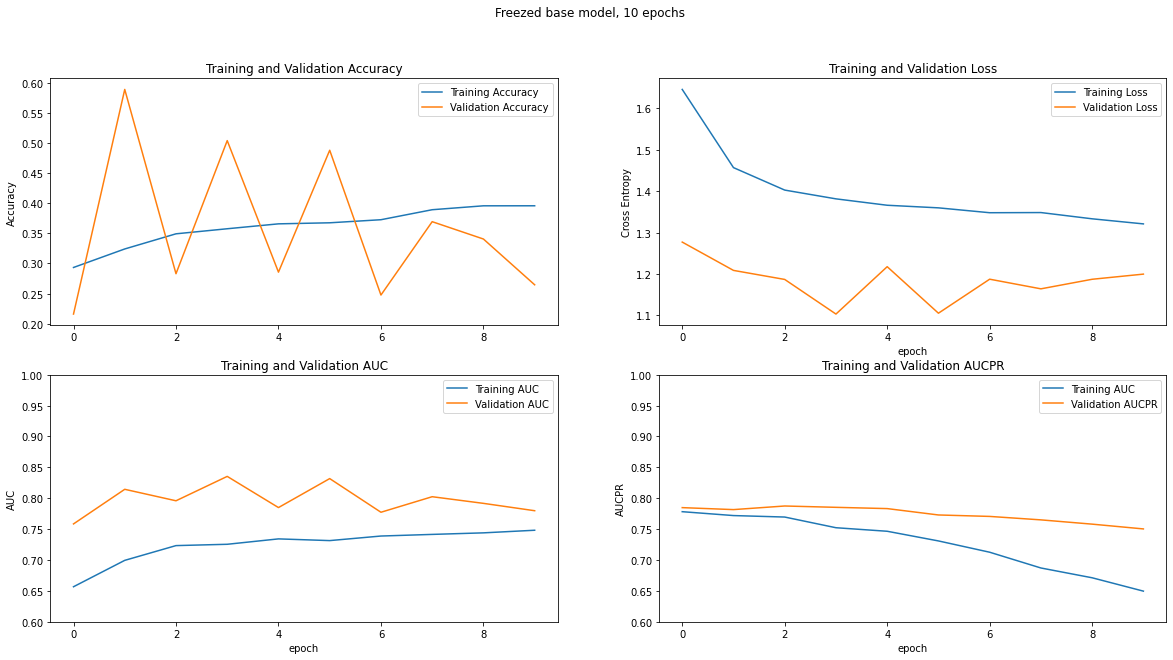

In [ ]:
plt.figure(figsize=(20, 10))
ncols = 2
nrows = 2
plt.suptitle('Freezed base model, 10 epochs')

plt.subplot(nrows, ncols, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),0.5])
plt.title('Training and Validation Accuracy')

plt.subplot(nrows, ncols, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
# plt.show()

plt.subplot(nrows, ncols, 3)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend()
plt.ylabel('AUC')
plt.ylim([0.6,1.0])
plt.title('Training and Validation AUC')
plt.xlabel('epoch')

plt.subplot(nrows, ncols, 4)
plt.plot(aucpr, label='Training AUCPR')
plt.plot(val_aucpr, label='Validation AUCPR')
plt.legend()
plt.ylabel('AUCPR')
plt.ylim([0.6,1.0])
plt.title('Training and Validation AUCPR')
plt.xlabel('epoch')
plt.show()

#### Confusion matrix

In [ ]:
val_predictions_baseline = tl_densenet.predict(val_ds, batch_size=BATCH_SIZE)
baseline_results = tl_densenet.evaluate(val_ds, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(tl_densenet.metrics_names, baseline_results):
    print(name, ': ', value)

loss :  1.1996290683746338
accuracy :  0.26460000872612
AUC :  0.7798232436180115
AUCPR :  0.345991849899292


Text(0.5, 24.0, 'Predicted label')

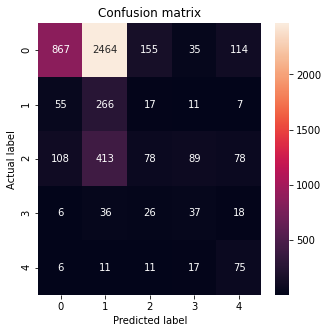

In [ ]:
labels = val_df['class'].astype('int8')
predictions = np.argmax(val_predictions_baseline, axis=1)

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Fine-tune 10 epochs (1st)

In [ ]:
base_densenet.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 300

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_densenet.layers[:fine_tune_at]:
    layer.trainable =  False

tl_densenet.summary()
print("Number of layers in the base model: ", len(base_densenet.layers))


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_12 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_6 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_13 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 1024)              4096

In [ ]:
tl_densenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy', tf.keras.metrics.AUC(name = 'AUC'), tf.keras.metrics.AUC(curve='PR', name = 'AUCPR')]
)

In [ ]:
init_epochs = 10
fine_tune_epochs = 10
total_epochs = init_epochs + fine_tune_epochs

history_densenet_fine = tl_densenet.fit(
    train_ds, 
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    class_weight = class_weight,
    epochs=total_epochs,
    initial_epoch=init_epochs
)

Epoch 11/20
1250/1250 [==============================] - 322s 250ms/step - loss: 1.2931 - accuracy: 0.3656 - AUC: 0.7379 - AUCPR: 0.3556 - val_loss: 1.1319 - val_accuracy: 0.3272 - val_AUC: 0.7960 - val_AUCPR: 0.3653
Epoch 12/20
1250/1250 [==============================] - 311s 249ms/step - loss: 1.2629 - accuracy: 0.3860 - AUC: 0.7466 - AUCPR: 0.3724 - val_loss: 1.1060 - val_accuracy: 0.4324 - val_AUC: 0.8208 - val_AUCPR: 0.4282
Epoch 13/20
1250/1250 [==============================] - 310s 248ms/step - loss: 1.2435 - accuracy: 0.4045 - AUC: 0.7556 - AUCPR: 0.3882 - val_loss: 1.1042 - val_accuracy: 0.4504 - val_AUC: 0.8231 - val_AUCPR: 0.4350
Epoch 14/20
1250/1250 [==============================] - 310s 248ms/step - loss: 1.2276 - accuracy: 0.4094 - AUC: 0.7601 - AUCPR: 0.3950 - val_loss: 1.1001 - val_accuracy: 0.4990 - val_AUC: 0.8317 - val_AUCPR: 0.4707
Epoch 15/20
1250/1250 [==============================] - 311s 248ms/step - loss: 1.2118 - accuracy: 0.4267 - AUC: 0.7651 - AUCPR: 0.

#### Carefully save things

In [ ]:
# filename = 'tl_densenet_fine1.h5'
# tl_densenet.save(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project', filename) )

# filename = 'history_densenet_fine1.pkl'
# with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project',filename), 'wb') as f:
#     pickle.dump(history_densenet_fine.history, f)

#### Reload if needed 

In [ ]:
# filename = 'tl_densenet_fine1.h5'
# tl_densenet = tf.keras.models.load_model(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project', filename))

# filename = 'history_densenet_fine1.pkl'
# with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project',filename), 'rb') as f:
#     history_densenet_fine1_history  = pickle.load(f)

#### Plot

In [ ]:
acc += history_densenet_fine.history['accuracy']
val_acc += history_densenet_fine.history['val_accuracy']

loss += history_densenet_fine.history['loss']
val_loss += history_densenet_fine.history['val_loss']

auc += history_densenet_fine.history['AUC']
val_auc += history_densenet_fine.history['val_AUC']

aucpr += history_densenet_fine.history['AUCPR']
val_aucpr += history_densenet_fine.history['val_AUCPR']

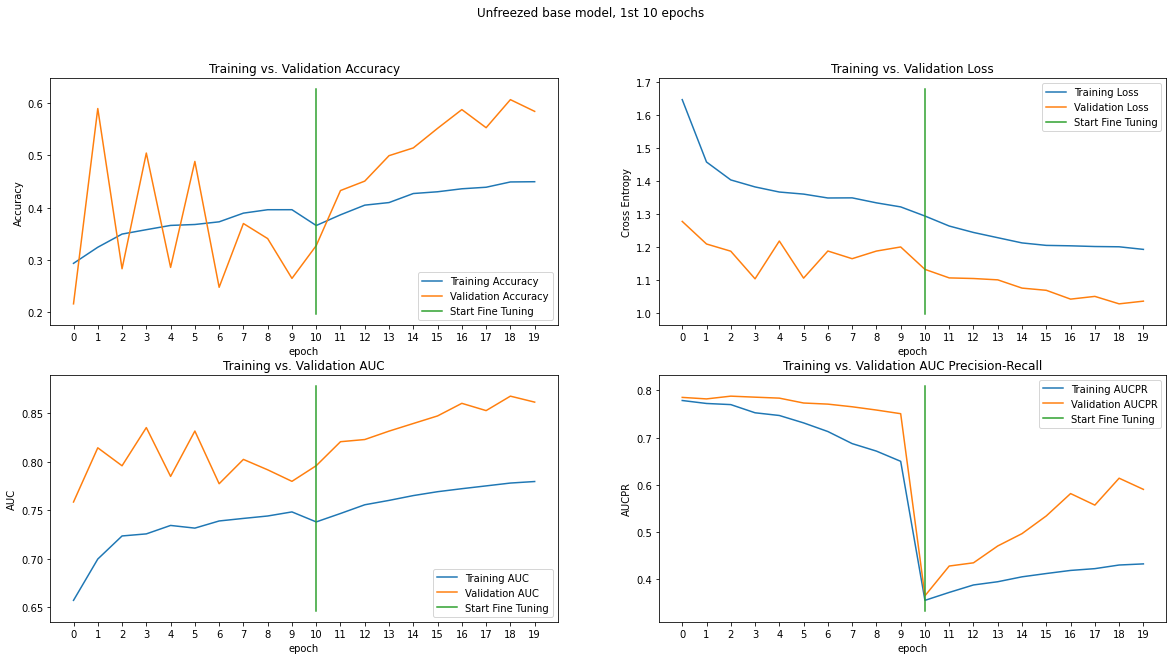

In [ ]:
plt.figure(figsize=(20, 10))
ncols = 2
nrows = 2
plt.suptitle('Unfreezed base model, 1st 10 epochs')

plt.subplot(nrows, ncols, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xticks(range(total_epochs))
# plt.ylim([0.9, 1])
plt.plot([10,10],
          plt.ylim(), label='Start Fine Tuning')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title('Training vs. Validation Accuracy')

plt.subplot(nrows, ncols, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xticks(range(total_epochs))
# plt.ylim([0, 0.5])
plt.plot([10,10],
         plt.ylim(), label='Start Fine Tuning')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')

plt.subplot(nrows, ncols, 3)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.xticks(range(total_epochs))
# plt.ylim([0, 0.5])
plt.plot([10,10],
         plt.ylim(), label='Start Fine Tuning')
plt.legend()
plt.title('Training vs. Validation AUC')
plt.xlabel('epoch')
plt.ylabel('AUC')

plt.subplot(nrows, ncols, 4)
plt.plot(aucpr, label='Training AUCPR')
plt.plot(val_aucpr, label='Validation AUCPR')
plt.xticks(range(total_epochs))
# plt.ylim([0, 0.5])
plt.plot([10,10],
         plt.ylim(), label='Start Fine Tuning')
plt.legend()
plt.title('Training vs. Validation AUC Precision-Recall')
plt.xlabel('epoch')
plt.ylabel('AUCPR')

plt.show()

#### Confusion matrix

In [ ]:
# train_predictions_baseline = tl_densenet.predict(train_ds, batch_size=BATCH_SIZE)
val_predictions_baseline = tl_densenet.predict(val_ds, batch_size=BATCH_SIZE)

In [ ]:
baseline_results = tl_densenet.evaluate(val_ds, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(tl_densenet.metrics_names, baseline_results):
    print(name, ': ', value)

loss :  1.035719871520996
accuracy :  0.5835999846458435
AUC :  0.8617187738418579
AUCPR :  0.5903064012527466


Text(0.5, 24.0, 'Predicted label')

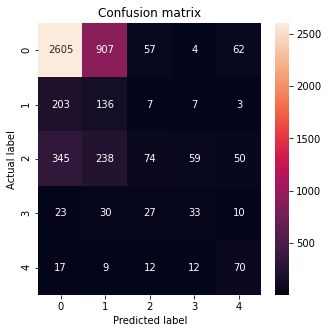

In [ ]:
labels = val_df['class'].astype('int8')
predictions = np.argmax(val_predictions_baseline, axis=1)

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(val_df['class'].astype('uint8'),predictions))

              precision    recall  f1-score   support

           0       0.82      0.72      0.76      3635
           1       0.10      0.38      0.16       356
           2       0.42      0.10      0.16       766
           3       0.29      0.27      0.28       123
           4       0.36      0.58      0.44       120

    accuracy                           0.58      5000
   macro avg       0.40      0.41      0.36      5000
weighted avg       0.68      0.58      0.61      5000



### Fine-tune 10 epoch (2nd)

In [ ]:
tl_densenet.summary()


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_12 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_6 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_13 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 1024)              4096

In [ ]:
initial_learning_rate = 1e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True)

In [ ]:
tl_densenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy', tf.keras.metrics.AUC(name = 'AUC'), tf.keras.metrics.AUC(curve='PR', name = 'AUCPR')]
)

In [ ]:
init_epochs = 40
fine_tune_epochs = 10
total_epochs = init_epochs + fine_tune_epochs

for i in range(4, 11):
    print(i, init_epochs, fine_tune_epochs, total_epochs, f'tl_densenet_fine{i}.h5', f'history_densenet_fine{i}.pkl')
    
    ## train
    history_densenet_fine = tl_densenet.fit(
        train_ds, 
        batch_size = BATCH_SIZE,
        validation_data=val_ds,
        class_weight = class_weight,
        epochs=total_epochs,
        initial_epoch=init_epochs
    )

    ## Save files
    filename = f'tl_densenet_fine{i}.h5'
    tl_densenet.save(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project', filename) )
    print(f"Saved model to {filename}")
    filename = f'history_densenet_fine{i}.pkl'
    with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project',filename), 'wb') as f:
        pickle.dump(history_densenet_fine.history, f)
    print(f"Saved history.history to {filename}")

    ## Concat the history
    acc += history_densenet_fine.history['accuracy']
    val_acc += history_densenet_fine.history['val_accuracy']

    loss += history_densenet_fine.history['loss']
    val_loss += history_densenet_fine.history['val_loss']

    auc += history_densenet_fine.history['AUC']
    val_auc += history_densenet_fine.history['val_AUC']

    aucpr += history_densenet_fine.history['AUCPR']
    val_aucpr += history_densenet_fine.history['val_AUCPR']

    ## Increase epoch setting
    init_epochs += fine_tune_epochs
    total_epochs = init_epochs + fine_tune_epochs

## Save for plot
filename = 'acc.pkl'
with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project',filename), 'wb') as f:
    pickle.dump(acc, f)
filename = 'val_acc.pkl'
with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project',filename), 'wb') as f:
    pickle.dump(val_acc, f)
filename = 'loss.pkl'
with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project',filename), 'wb') as f:
    pickle.dump(loss, f)
filename = 'val_loss.pkl'
with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project',filename), 'wb') as f:
    pickle.dump(val_loss, f)
filename = 'auc.pkl'
with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project',filename), 'wb') as f:
    pickle.dump(auc, f)
filename = 'val_auc.pkl'
with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project',filename), 'wb') as f:
    pickle.dump(val_auc, f)
filename = 'aucpr.pkl'
with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project',filename), 'wb') as f:
    pickle.dump(aucpr, f)
filename = 'val_aucpr.pkl'
with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project',filename), 'wb') as f:
    pickle.dump(val_aucpr, f)

4 40 10 50 tl_densenet_fine4.h5 history_densenet_fine4.pkl
Epoch 41/50
1250/1250 [==============================] - 718s 544ms/step - loss: 1.1578 - accuracy: 0.4720 - AUC: 0.8019 - AUCPR: 0.4623 - val_loss: 1.0024 - val_accuracy: 0.6126 - val_AUC: 0.8756 - val_AUCPR: 0.6313
Epoch 42/50
1250/1250 [==============================] - 301s 241ms/step - loss: 1.1639 - accuracy: 0.4694 - AUC: 0.7989 - AUCPR: 0.4506 - val_loss: 1.0333 - val_accuracy: 0.5514 - val_AUC: 0.8557 - val_AUCPR: 0.5477
Epoch 43/50
1250/1250 [==============================] - 300s 240ms/step - loss: 1.1605 - accuracy: 0.4719 - AUC: 0.7994 - AUCPR: 0.4573 - val_loss: 1.0252 - val_accuracy: 0.5666 - val_AUC: 0.8606 - val_AUCPR: 0.5695
Epoch 44/50
1250/1250 [==============================] - 299s 239ms/step - loss: 1.1562 - accuracy: 0.4703 - AUC: 0.7997 - AUCPR: 0.4553 - val_loss: 1.0036 - val_accuracy: 0.5982 - val_AUC: 0.8728 - val_AUCPR: 0.6157
Epoch 45/50
1250/1250 [==============================] - 302s 241ms/step 

In [ ]:
# init_epochs = 20
# fine_tune_epochs = 10
# total_epochs = init_epochs + fine_tune_epochs

# history_densenet_fine = tl_densenet.fit(
#     train_ds, 
#     batch_size = BATCH_SIZE,
#     validation_data=val_ds,
#     class_weight = class_weight,
#     epochs=total_epochs,
#     initial_epoch=init_epochs
# )

#### Carefully save things

In [ ]:
# filename = 'tl_densenet_fine3.h5'
# tl_densenet.save(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project', filename) )

# filename = 'history_densenet_fine3.pkl'
# with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project',filename), 'wb') as f:
#     pickle.dump(history_densenet_fine.history, f)

#### Reload if needed 

In [ ]:
# filename = 'tl_densenet_fine3.h5'
# tl_densenet = tf.keras.models.load_model(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project', filename))

# filename = 'history_densenet_fine3.pkl'
# with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project',filename), 'rb') as f:
#     history_load  = pickle.load(f)

# acc += history_load['accuracy']
# val_acc += history_load['val_accuracy']

# loss += history_load['loss']
# val_loss += history_load['val_loss']

# auc += history_load['AUC']
# val_auc += history_load['val_AUC']

# aucpr += history_load['AUCPR']
# val_aucpr += history_load['val_AUCPR']

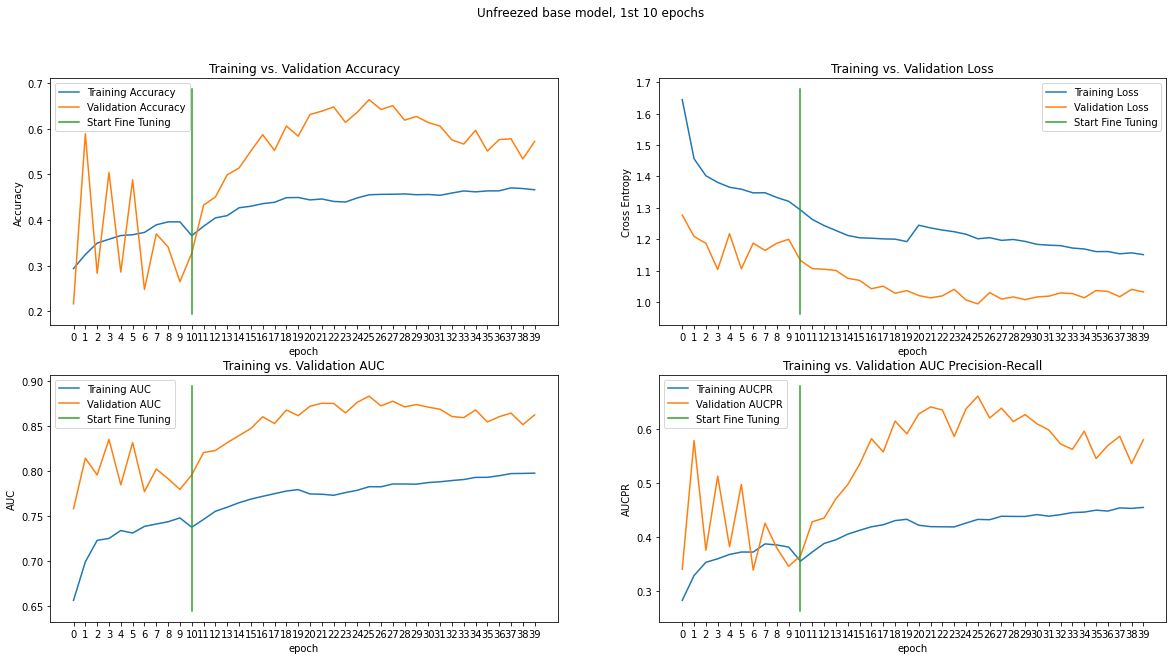

In [ ]:
#@title plot loaded metrics
# plt.figure(figsize=(20, 10))
# ncols = 2
# nrows = 2
# plt.suptitle('Unfreezed base model, 1st 10 epochs')
# total_epochs=40

# plt.subplot(nrows, ncols, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.xticks(range(total_epochs))
# # plt.ylim([0.9, 1])
# plt.plot([10,10],
#           plt.ylim(), label='Start Fine Tuning')
# plt.legend()
# plt.ylabel('Accuracy')
# plt.xlabel('epoch')
# plt.title('Training vs. Validation Accuracy')

# plt.subplot(nrows, ncols, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.xticks(range(total_epochs))
# # plt.ylim([0, 0.5])
# plt.plot([10,10],
#          plt.ylim(), label='Start Fine Tuning')
# plt.legend()
# plt.title('Training vs. Validation Loss')
# plt.xlabel('epoch')
# plt.ylabel('Cross Entropy')

# plt.subplot(nrows, ncols, 3)
# plt.plot(auc, label='Training AUC')
# plt.plot(val_auc, label='Validation AUC')
# plt.xticks(range(total_epochs))
# # plt.ylim([0, 0.5])
# plt.plot([10,10],
#          plt.ylim(), label='Start Fine Tuning')
# plt.legend()
# plt.title('Training vs. Validation AUC')
# plt.xlabel('epoch')
# plt.ylabel('AUC')

# plt.subplot(nrows, ncols, 4)
# plt.plot(aucpr, label='Training AUCPR')
# plt.plot(val_aucpr, label='Validation AUCPR')
# plt.xticks(range(total_epochs))
# # plt.ylim([0, 0.5])
# plt.plot([10,10],
#          plt.ylim(), label='Start Fine Tuning')
# plt.legend()
# plt.title('Training vs. Validation AUC Precision-Recall')
# plt.xlabel('epoch')
# plt.ylabel('AUCPR')

# plt.show()

#### Plot

In [ ]:
acc += history_densenet_fine.history['accuracy']
val_acc += history_densenet_fine.history['val_accuracy']

loss += history_densenet_fine.history['loss']
val_loss += history_densenet_fine.history['val_loss']

auc += history_densenet_fine.history['AUC']
val_auc += history_densenet_fine.history['val_AUC']

aucpr += history_densenet_fine.history['AUCPR']
val_aucpr += history_densenet_fine.history['val_AUCPR']

In [ ]:
plt.figure(figsize=(20, 10))
ncols = 2
nrows = 2
plt.suptitle('Unfreezed base model, 1st 10 epochs')

plt.subplot(nrows, ncols, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xticks(range(total_epochs))
# plt.ylim([0.9, 1])
plt.plot([10,10],
          plt.ylim(), label='Start Fine Tuning')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title('Training vs. Validation Accuracy')

plt.subplot(nrows, ncols, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xticks(range(total_epochs))
# plt.ylim([0, 0.5])
plt.plot([10,10],
         plt.ylim(), label='Start Fine Tuning')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')

plt.subplot(nrows, ncols, 3)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.xticks(range(total_epochs))
# plt.ylim([0, 0.5])
plt.plot([10,10],
         plt.ylim(), label='Start Fine Tuning')
plt.legend()
plt.title('Training vs. Validation AUC')
plt.xlabel('epoch')
plt.ylabel('AUC')

plt.subplot(nrows, ncols, 4)
plt.plot(aucpr, label='Training AUCPR')
plt.plot(val_aucpr, label='Validation AUCPR')
plt.xticks(range(total_epochs))
# plt.ylim([0, 0.5])
plt.plot([10,10],
         plt.ylim(), label='Start Fine Tuning')
plt.legend()
plt.title('Training vs. Validation AUC Precision-Recall')
plt.xlabel('epoch')
plt.ylabel('AUCPR')

plt.show()

#### Confusion matrix

In [ ]:
# train_predictions_baseline = tl_densenet.predict(train_ds, batch_size=BATCH_SIZE)
test_predictions_baseline = tl_densenet.predict(val_ds, batch_size=BATCH_SIZE)

In [ ]:
test_predictions_baseline.shape

(5000, 5)

In [ ]:
baseline_results = tl_densenet.evaluate(val_ds, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(tl_densenet.metrics_names, baseline_results):
    print(name, ': ', value)

loss :  0.8113721609115601
accuracy :  0.746999979019165
AUC :  0.9232354760169983
AUCPR :  0.7826986312866211


Text(0.5, 24.0, 'Predicted label')

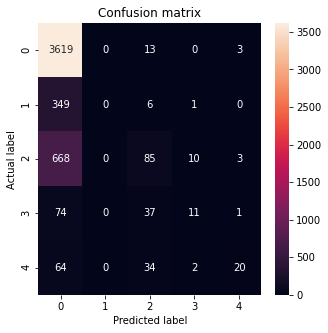

In [ ]:
labels = val_df['class'].astype('int8')
predictions = np.argmax(test_predictions_baseline, axis=1)

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(val_df['class'].astype('uint8'),predictions))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      3635
           1       0.00      0.00      0.00       356
           2       0.49      0.11      0.18       766
           3       0.46      0.09      0.15       123
           4       0.74      0.17      0.27       120

    accuracy                           0.75      5000
   macro avg       0.49      0.27      0.29      5000
weighted avg       0.65      0.75      0.66      5000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## InceptionV3

In [ ]:
from tensorflow.keras.applications import inception_v3

### Build model

In [ ]:
base_inception = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False, 
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3) 
)
base_inception.trainable = False

87916544/87910968 [==============================] - 2s 0us/step


In [ ]:
len(base_inception.layers)

311

In [ ]:
def make_tl_inception():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE,3))
    x = inception_v3.preprocess_input(inputs)
    x = base_inception(x, training = False)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    
    return model

tl_inception = make_tl_inception()
tl_inception.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_14 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_105 (Bat (None, 2048)              8192      
_________________________________________________________________
dropout_11 (Dropout)         (None, 2048)              0   

### Train

In [ ]:
initial_learning_rate = 1e-2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=600,
    decay_rate=0.90,
    staircase=True)

In [ ]:
# lr = 1e-2
n_epochs = 20

tl_inception.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy', tf.keras.metrics.AUC()]
)

history_inception = tl_inception.fit(
    train_ds,
    # steps_per_epoch = 200,
    batch_size = BATCH_SIZE,
    val_ds,
    # validation_steps = 20,
    # callbacks = make_callbacks(),
    epochs = n_epochs
)

Epoch 1/20
647/647 [==============================] - 301s 420ms/step - loss: 5.1286 - accuracy: 0.2791 - auc_3: 0.5864 - val_loss: 3.6776 - val_accuracy: 0.3021 - val_auc_3: 0.6044
Epoch 2/20
647/647 [==============================] - 21s 33ms/step - loss: 2.4611 - accuracy: 0.3096 - auc_3: 0.6303 - val_loss: 1.8123 - val_accuracy: 0.3418 - val_auc_3: 0.6499
Epoch 3/20
647/647 [==============================] - 22s 34ms/step - loss: 1.6378 - accuracy: 0.3322 - auc_3: 0.6679 - val_loss: 1.5401 - val_accuracy: 0.3518 - val_auc_3: 0.6702
Epoch 4/20
647/647 [==============================] - 22s 34ms/step - loss: 1.5174 - accuracy: 0.3392 - auc_3: 0.6819 - val_loss: 1.5072 - val_accuracy: 0.3291 - val_auc_3: 0.6776
Epoch 5/20
647/647 [==============================] - 22s 34ms/step - loss: 1.4960 - accuracy: 0.3379 - auc_3: 0.6860 - val_loss: 1.4716 - val_accuracy: 0.3362 - val_auc_3: 0.6880
Epoch 6/20
647/647 [==============================] - 22s 34ms/step - loss: 1.4872 - accuracy: 0.3

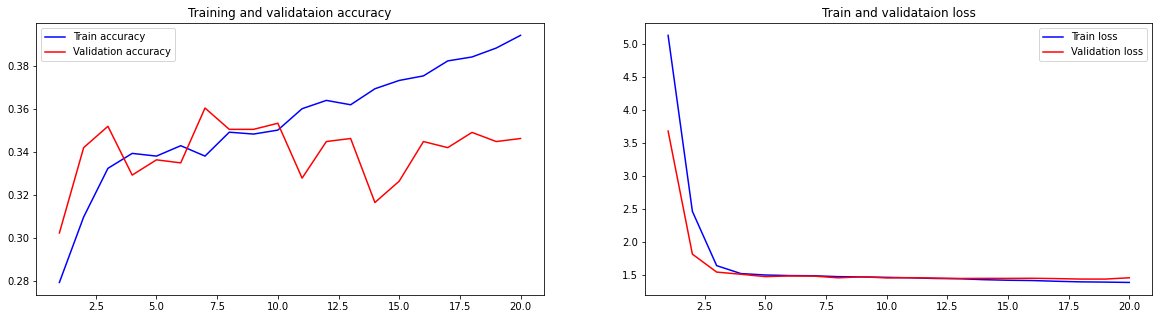

In [ ]:
plot_acc_loss(history_inception)

In [ ]:
# import pickle
# fname = 'history_inception.pkl'
# histhist = history_inception.history
# with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project',fname), 'wb') as f:
#     pickle.dump(histhist, f)

### x

In [ ]:
# from sklearn.metrics import roc_auc_score
# def auc_score(y_true, y_pred):
#     if len(np.unique(y_true[:,1])) == 1:
#         return 0.5
#     else:
#         return roc_auc_score(y_true, y_pred)
# def auc(y_true, y_pred):
#     return tf.py_func(auc1, (y_true, y_pred), tf.double)
# #in model.compile you can use auc function name
# model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=[auc])

In [ ]:
y_pred = tl_inception.predict(make_val_ds(val_df.iloc[:5,:]), batch_size = BATCH_SIZE, verbose = 2)
# y_pred = tf.argmax(y_pred)
y_pred, val_df['class'][:5]

In [ ]:
np.amax(y_pred,axis=1)

array([0.84635913, 0.9131071 , 0.9300751 , 0.9244159 , 0.9868739 ],
      dtype=float32)

In [ ]:
lr = 1e-3
n_epochs = 10
from sklearn.metrics import f1_score, auc


tl_inception.compile(
    optimizer = Adam(learning_rate = lr), 
    loss = 'sparse_categorical_crossentropy', 
    metrics = [auc]
)

history_inception = tl_inception.fit(
    make_train_ds(train_df),
    # steps_per_epoch = 200,
    batch_size = BATCH_SIZE,
    validation_data = make_val_ds(val_df),
    # validation_steps = 20,
    callbacks = make_callbacks(),
    epochs = n_epochs
)

## Feature extract

In [ ]:
from tensorflow.keras.applications import vgg16

In [ ]:
base_model = tf.keras.applications.VGG16(
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False
)

base_model.summary()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

def extract_features(df), sample_count, train=True):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count))


    generator = datagen.flow_from_directory(
                        directory,
                        target_size=(224, 224),
                        batch_size=BATCH_SIZE,
                        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        # inputs_batch shape : (BATCH_SIZE, *target_size, n_channels)
        # labels_batch shape : (BATCH_SIZE,)
        features_batch = base_model.predict(inputs_batch)
        features[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = features_batch
        labels[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = labels_batch
        i += 1
        if i%10==0:
          print('Batch', i)
        
        if i * BATCH_SIZE >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been feature-extracted once.
            break
    return features, labels

print(train_dir)
print(val_dir)

%time train_features, train_labels = extract_features(train_dir, 2000)
%time validation_features, validation_labels = extract_features(val_dir, 1000)

In [ ]:
train_features = np.reshape(train_features, (2000, 7*7*512))
validation_features = np.reshape(validation_features, (1000, 7*7*512))

## EfficientNetB7

In [ ]:
from tensorflow.keras.applications import efficientnet

### Build model

In [ ]:
base_effnet = efficientnet.EfficientNetB7(
    input_shape=(IMG_SIZE, IMG_SIZE, 3), 
    include_top=False, 
    weights='imagenet'
)
base_effnet.trainable = False

258080768/258076736 [==============================] - 2s 0us/step


In [ ]:
def make_tl_effnet():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE,3))

    x = efficientnet.preprocess_input(inputs)
    x = base_effnet(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(5, 'softmax')(x)

    model = Model(inputs, outputs)

    return model

tl_effnet = make_tl_effnet()
tl_effnet.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2560)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 2560)              10240     
_________________________________________________________________
dropout_3 (Dropout)          (None, 2560)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 12805     
Total params: 64,120,732
Trainable params: 17,925
Non-trainable params: 64,102,807
__________________________________________

### Train

In [ ]:
0.9**(67*647/600)

0.0004944217522997923

In [ ]:
# lr = 1e-3
n_epochs = 250
initial_learning_rate = 1e-2

cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode = 'max',
    restore_best_weights=True
)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

tl_effnet.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy', tf.keras.metrics.AUC()]
)

history_effnet = tl_effnet.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    callbacks = [cb_earlystop],
    epochs = n_epochs
)

Epoch 1/250
647/647 [==============================] - 76s 93ms/step - loss: 1.8877 - accuracy: 0.3204 - auc_6: 0.6522 - val_loss: 2.3793 - val_accuracy: 0.2298 - val_auc_6: 0.6064
Epoch 2/250
647/647 [==============================] - 55s 85ms/step - loss: 1.7794 - accuracy: 0.3296 - auc_6: 0.6581 - val_loss: 2.1074 - val_accuracy: 0.2468 - val_auc_6: 0.6027
Epoch 3/250
647/647 [==============================] - 55s 86ms/step - loss: 1.7589 - accuracy: 0.3182 - auc_6: 0.6530 - val_loss: 1.8561 - val_accuracy: 0.2851 - val_auc_6: 0.6188
Epoch 4/250
647/647 [==============================] - 55s 86ms/step - loss: 1.7222 - accuracy: 0.3172 - auc_6: 0.6502 - val_loss: 1.9812 - val_accuracy: 0.2596 - val_auc_6: 0.5968
Epoch 5/250
647/647 [==============================] - 56s 86ms/step - loss: 1.7174 - accuracy: 0.3161 - auc_6: 0.6545 - val_loss: 2.0590 - val_accuracy: 0.2454 - val_auc_6: 0.5888
Epoch 6/250
647/647 [==============================] - 55s 85ms/step - loss: 1.7468 - accuracy:

KeyboardInterrupt: ignored

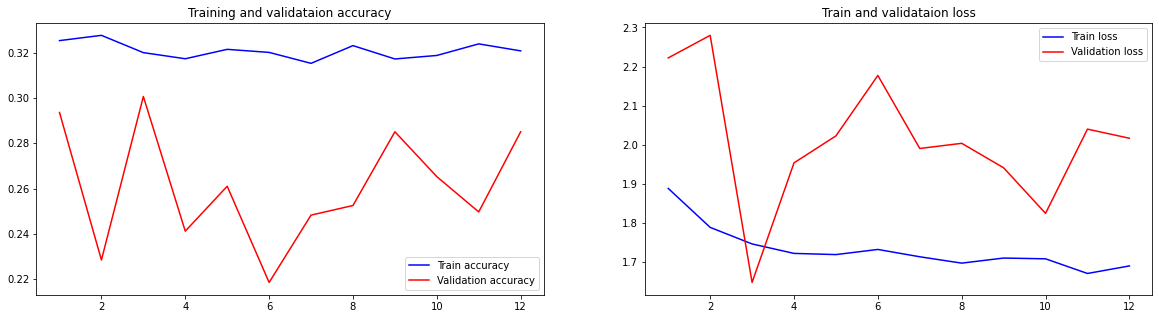

In [ ]:
plot_acc_loss(history_effnet)

In [ ]:
import pickle
with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project','history_effnet_circle.pkl'), 'wb') as f:
    pickle.dump(history_effnet.history, f)

## VGG16

In [ ]:
from tensorflow.keras.applications import vgg16

In [ ]:
base_vgg = vgg16.VGG16(
    include_top=False, weights='imagenet', 
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_vgg.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
len(base_vgg.layers)

19

In [ ]:
### Try with one batch 
# image_batch, label_batch = next(iter(train_ds))

# x = vgg16.preprocess_input(image_batch)
# x = vgg16_base(x, training=False)#
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.2)(x)
# x = Dense(5, activation = 'softmax')(x)

# print(x)
# print(np.argmax(x, axis = 1))
# print(label_batch)

### Build model

In [ ]:
def make_tl_vgg():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = vgg16.preprocess_input(inputs)
    x = base_vgg(x, training=False)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(5, activation = 'softmax')(x)
    
    tl_model_vgg16 = tf.keras.Model(inputs, outputs)
    
    return tl_model_vgg16

tl_vgg = make_tl_vgg()
tl_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565  

### Train

In [ ]:
lr = 1e-5
n_epochs = 10

tl_vgg.compile(
    optimizer = Adam(learning_rate=1e-3), 
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['accuracy']
)

history_vgg = tl_vgg.fit(
    make_train_ds(train_df),
    # steps_per_epoch = 200,
    batch_size = BATCH_SIZE,
    validation_data = make_val_ds(val_df),
    # validation_steps = 20,
    callbacks = make_callbacks(),
    epochs = n_epochs
)

Epoch 1/10
647/647 [==============================] - 695s 979ms/step - loss: 0.9973 - accuracy: 0.6665 - val_loss: 5.2524 - val_accuracy: 0.0240
Epoch 2/10
647/647 [==============================] - 27s 41ms/step - loss: 0.8789 - accuracy: 0.7182 - val_loss: 5.0474 - val_accuracy: 0.0240
Epoch 3/10
647/647 [==============================] - 27s 41ms/step - loss: 0.8553 - accuracy: 0.7252 - val_loss: 5.0376 - val_accuracy: 0.0240
Epoch 4/10
647/647 [==============================] - 27s 42ms/step - loss: 0.8505 - accuracy: 0.7269 - val_loss: 5.0372 - val_accuracy: 0.0240
Epoch 5/10
647/647 [==============================] - 27s 42ms/step - loss: 0.8466 - accuracy: 0.7279 - val_loss: 5.0641 - val_accuracy: 0.0240
Epoch 6/10
647/647 [==============================] - 27s 42ms/step - loss: 0.8496 - accuracy: 0.7267 - val_loss: 5.0616 - val_accuracy: 0.0240
Epoch 7/10
647/647 [==============================] - 27s 42ms/step - loss: 0.8452 - accuracy: 0.7256 - val_loss: 5.0431 - val_accurac

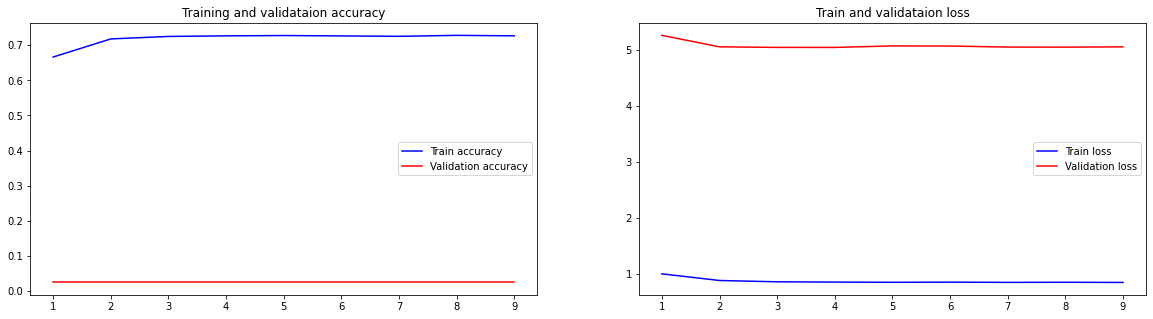

In [ ]:
plot_acc_loss(history_vgg)

In [ ]:
import pickle
with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project','history_vgg_circle.pkl'), 'wb') as f:
    pickle.dump(history_vgg.history, f)

## MobileNetv2

In [ ]:
from tensorflow.keras.applications import mobilenet_v2

In [ ]:
base_mobile = mobilenet_v2.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE,3 ), include_top=False, 
    weights='imagenet', pooling='avg'
)
base_mobile.trainable = False

### Test forward pass

In [ ]:
# test with one batch
# %%time
# image_batch, label_batch = next(iter(train_ds))

In [ ]:
# %%time
# x = mobilenet_v2.preprocess_input(image_batch)
# x = mobilenet_base(x, training=False)#
# x = Dropout(0.2)(x)
# x = Dense(5, 'softmax')(x)

# print(x)
# print(np.argmax(x, axis = 1))
# print(label_batch)

### Build model

In [ ]:
def make_tl_mobile():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE,3))
    
    x = mobilenet_v2.preprocess_input(inputs)
    x = base_mobile(x, training=False)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(5, 'softmax')(x)

    model = Model(inputs, outputs)
    return model

tl_mobile = make_tl_mobile()
tl_mobile.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405  

### Train

In [ ]:
lr = 1e-3
n_epochs = 10

tl_mobile.compile(
    optimizer = Adam(learning_rate = lr), 
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['accuracy']
)

history_mobilenet = tl_mobile.fit(
    make_train_ds(train_df),
    # steps_per_epoch = 200,
    batch_size = BATCH_SIZE,
    validation_data = make_val_ds(val_df),
    # validation_steps = 20,
    callbacks = make_callbacks(),
    epochs = n_epochs
)

Epoch 1/10
647/647 [==============================] - 693s 954ms/step - loss: 0.8122 - accuracy: 0.7153 - val_loss: 6.4151 - val_accuracy: 0.0240
Epoch 2/10
647/647 [==============================] - 14s 22ms/step - loss: 0.8588 - accuracy: 0.7114 - val_loss: 5.2409 - val_accuracy: 0.0240
Epoch 3/10
647/647 [==============================] - 14s 22ms/step - loss: 0.8485 - accuracy: 0.7136 - val_loss: 5.2365 - val_accuracy: 0.0240
Epoch 4/10
647/647 [==============================] - 14s 22ms/step - loss: 0.8197 - accuracy: 0.7152 - val_loss: 5.3614 - val_accuracy: 0.0240
Epoch 5/10
647/647 [==============================] - 14s 22ms/step - loss: 0.8215 - accuracy: 0.7167 - val_loss: 5.1719 - val_accuracy: 0.0240
Epoch 6/10
647/647 [==============================] - 14s 22ms/step - loss: 0.8290 - accuracy: 0.7186 - val_loss: 5.3185 - val_accuracy: 0.0240
Epoch 7/10
647/647 [==============================] - 14s 22ms/step - loss: 0.8163 - accuracy: 0.7172 - val_loss: 5.3097 - val_accurac

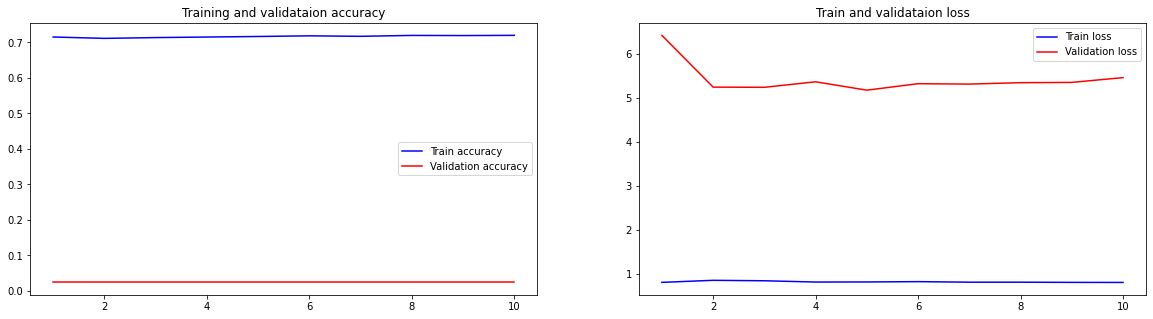

In [ ]:
plot_acc_loss(history_mobilenet)

In [ ]:
import pickle
with open(os.path.join('/content/drive/MyDrive/1_CS_MLE/final_project','history_mobilenet_circle.pkl'), 'wb') as f:
    pickle.dump(history_mobilenet.history, f)

# EDA

In [ ]:
# Verify whether one patient has 2 different diagnosis on his/her eyes
# data15 = df[df['year'] == 2015]

# def get_patientID(row):
#     tmp = row['filename'].split('_')
#     return int(tmp[0])

# def get_eye(row):
#     tmp = row['filename'].split('_')
#     return tmp[1]

    
# data15.insert(3, 'patient_id', data15.apply(get_patientID, axis = 1), True)
# data15.insert(4, 'eye', data15.apply(get_eye, axis = 1), True)
# data15.head()

# patient_eye_diagnose = pd.pivot_table(
#     data15, 
#     index = 'patient_id',
#     columns = 'eye',
#     values = 'diagnosis',
#     aggfunc = 'sum').reset_index()

# patient_eye_diagnose.head()

# (patient_eye_diagnose['left'] != patient_eye_diagnose['right']).sum()

There are 5563 patients with different diagnosis on their eyes

In [ ]:
# Check for any filename other than jpg
# for item in raw_data_path.glob('**/*') :
#     if (item.is_file()) and (item.name.split('.')[-1] != 'jpg'):
#         print(item)

In [ ]:
# Organize data into forlders (obsolete)

# create directories to organize the data
# folder_1 = 'data'
# print(folder_1)
# os.makedirs(folder_1, exist_ok=True)
# for level in index_class.keys():
#     folder_2 = os.path.join(folder_1,f'{level}_{index_class[level]}')
#     print(folder_2)
#     os.makedirs(folder_2, exist_ok=True)

# raw_data_path = pathlib.Path(RAW_DATA_FOLDER)
# raw_data_path

# for item in raw_data_path.glob('**/*') :
#     if item.is_file():
#         fname = item.name.split('.')[0]
#         image_class = df[df['filename'] == fname]['diagnosis'].values[0]
#         dest_folder = os.path.join('data',f'{image_class}_{index_class[image_class]}')
#         shutil.move(str(item), dest_folder)